# Notebook For Figure 3 Method Paper

### Imports  
All functions are in behavior_analysis_functions.py

In [122]:
import os
import glob
from processing_TowerCoordinates import *
from processing_session_trajectory import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.path as mpath
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pickle
import scipy.ndimage as ndimage
from scipy.stats import wilcoxon
from processing_TowerCoordinates import *
from datetime import date
from scipy.ndimage import gaussian_filter as smooth
import matplotlib.colors as mcolors

import warnings 
from matplotlib.colors import LinearSegmentedColormap


plt.style.use('paper.mplstyle')

#from PlottingFunctions import *




# Getting mice data
Define the folder where your MOUXXX folder are, generate a list of MOUXXX folders and for each mice a list of sessions

In [123]:
# Finding and importing data

# indicate where the data are
# path_to_data_folder is the path of the folder where you store your different mice.

# Windows:

path_to_data_folder='/LocalData/ForagingMice/4TowerTaskMethodPaper/KenzaData'



pattern_of_MOU_Folders = os.path.join(path_to_data_folder, "MOU*")

# List all mice in the data folder (If you want to process all the mice in your data folder),
mice_list = [os.path.basename(path) for path in glob.glob(pattern_of_MOU_Folders)]
mice_list=sorted(mice_list)

# Print the number of mice, the list of mice, and add an empty line
print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder: {", ".join(mice_list)}\n')


#If you want to process a subset of mice uncomment the line below and comment the 2 lines above

#mice_list: list[str] = ["MOU2334"]  # For processing  a single mice. Equivalent to mice_list = ["MOU2334"] but more correct as it forces to create a list of string
#mice_list=['MOU2329', 'MOU2330', 'MOU2331', 'MOU2332', 'MOU2333', 'MOU2334']
#print(f'Found {len(mice_list)} {"mice" if len(mice_list) > 1 else "mouse"} in the data folder:')

session_list = {}
for mouse in mice_list:
    mouse_folder = os.path.join(path_to_data_folder,mouse)
    session_list[mouse] = sorted([name for name in os.listdir(mouse_folder)
                           if os.path.isdir(os.path.join(mouse_folder, name))
                           and name.startswith('MOU')])
    nb_sessions = len(session_list[mouse])
    print(f'Hello, I\'m {mouse}! I have foraged for {nb_sessions} sessions:')
    print(session_list[mouse], '\n')


Found 36 mice in the data folder: MOUKA266, MOUKA267, MOUKA268, MOUKA269, MOUKA270, MOUKA271, MOUKA274, MOUKA275, MOUKA276, MOUKA277, MOUKA278, MOUKA279, MOUKA286, MOUKA287, MOUKA288, MOUKA289, MOUKA290, MOUKA291, MOUKA296, MOUKA297, MOUKA298, MOUKA299, MOUKA300, MOUKA301, MOUKA302, MOUKA303, MOUKA304, MOUKA305, MOUKA306, MOUKA307, MOUKA308, MOUKA309, MOUKA310, MOUKA311, MOUKA312, MOUKA313

Hello, I'm MOUKA266! I have foraged for 17 sessions:
['MOUKA266_20230531-1433', 'MOUKA266_20230601-0925', 'MOUKA266_20230601-1507', 'MOUKA266_20230602-0857', 'MOUKA266_20230602-1450', 'MOUKA266_20230605-0924', 'MOUKA266_20230605-1606', 'MOUKA266_20230606-1052', 'MOUKA266_20230606-1626', 'MOUKA266_20230607-0929', 'MOUKA266_20230607-1439', 'MOUKA266_20230608-0949', 'MOUKA266_20230608-1538', 'MOUKA266_20230609-1034', 'MOUKA266_20230609-1604', 'MOUKA266_20230612-0941', 'MOUKA266_20230612-1505'] 

Hello, I'm MOUKA267! I have foraged for 18 sessions:
['MOUKA267_20230531-1519', 'MOUKA267_20230601-0939', 'M

# Definition of functions

In [124]:
# def cm2inch(value):

def cm2inch(value):
    return value/2.54

In [125]:
def finding_mouse_rewarded_direction(folder_path_mouse_to_process):
# Looking for the rewarded direction FOR ALL THE SESSIONS

    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])

    output_pickle_filename = f"{sessions_to_process[-1]}_basic_processing_output.pickle"
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, sessions_to_process[-1], output_pickle_filename)

    #with open(output_pickle_filepath, 'rb') as file:
    #        session_data = pickle.load(file)

    session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_process,sessions_to_process[-1])

    rewarded_direction_degrees = session_param_df["potentialRewardedDirections"][0]

    if rewarded_direction_degrees == '[270]':

        rewarded_direction = 'CW'

    elif rewarded_direction_degrees == '[90]':
        
        rewarded_direction = 'CCW'
        
    else:

        print('ERROR')

        return 

    return rewarded_direction
    
    #

In [126]:
def rewards_by_patch(runs_around_tower, good_direction):

    visits = []

    previous_turn_patch = ''

    n = -1

    for run_around_tower in runs_around_tower:

        is_good_turn = run_around_tower[3]['direction'] == good_direction
        max_rewards = run_around_tower[3]['max_rewards']
        patch = run_around_tower[1][0]

        if patch != previous_turn_patch:

            n = n + 1
            
            visits.append({})

            visits[n]['turns'] = 1
            visits[n]['good_turns'] = int(is_good_turn)
            visits[n]['max_reward'] = max_rewards
            visits[n]['patch'] = patch
            visits[n]['visit_time'] = run_around_tower[4]['epoch_time']


        else:

            visits[n]['good_turns'] += int(is_good_turn)
            visits[n]['turns'] += 1

        previous_turn_patch = patch

    #print(visit)

    return visits



In [127]:
def plot_realised_vs_max(folder_path_mouse_to_process, session_idx_to_process, ax):

    sessions_to_process = sorted([name for name in os.listdir(folder_path_mouse_to_process)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_process, name))
                                  and name.startswith('MOU')])

    session_to_process = sessions_to_process[session_idx_to_process-1]

    output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
    output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
    
    # Load the pickle file
    with open(output_pickle_filepath, 'rb') as file:
        session_data = pickle.load(file)

    runs_around_towers = session_data['all_epochs']['run_around_tower']


    good_direction = finding_mouse_rewarded_direction(folder_path_mouse_to_process)

    visits = rewards_by_patch(runs_around_towers, good_direction)
    

    cmap = plt.cm.viridis
    norm = Normalize(vmin=0, vmax=session_data['timeofframes'][-1])

    max_rewardsgood_turns = 0

    val = 0

    for i in range(len(visits)):
    
        visit_time = visits[i]['visit_time']

        max_reward = visits[i]['max_reward']
        good_turns = visits[i]['good_turns']
        
        ax.plot([1,2], [max_reward,good_turns], marker='o', markersize=3, alpha=0.3, color=cmap(norm(visit_time)))

        max_rewardsgood_turns = max(max_rewardsgood_turns,good_turns)

        val += good_turns
        

        """output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)"""


    #ax.set_ylabel('')
    ax.set_xticks([1, 2], ['max reward', f'good turns'], fontsize=5)
    ax.set_xlim([0.5,2.5])

    ax.set_yticks(np.arange(0, max_rewardsgood_turns + 1, 1))



In [128]:
def plot_realised_vs_max_per_session(path_to_data_folder, mice_list, first_session, last_session, ax):

    med_realised_vs_max_per_session_per_mouse = []
    
    for mouse in mice_list:

        folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)

    # Get the list of sessions
        sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                    if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                    and name.startswith('MOU')])

        good_direction = finding_mouse_rewarded_direction(folder_path_mouse_to_analyse)
        
        med_realised_vs_max_per_session = []

        for session_to_analyse in sessions_to_analyse[first_session:last_session]:

            output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"
            output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)
            
            # Load the pickle file
            with open(output_pickle_filepath, 'rb') as file:
                session_data = pickle.load(file)

            runs_around_towers = session_data['all_epochs']['run_around_tower']
        
            visit = rewards_by_patch(runs_around_towers,good_direction)
            
            total_max_reward = 0
            total_good_turns = 0

            max_vs_realised = []

            for i in range(len(visit)):

                total_max_reward = visit[i]['max_reward']
                total_good_turns = visit[i]['good_turns']

                max_vs_realised.append(total_good_turns/total_max_reward)
                
            med_realised_vs_max_per_session.append(np.median(max_vs_realised))
        
        med_realised_vs_max_per_session_per_mouse.append(med_realised_vs_max_per_session)

        #sessions_idx = np.arange(1,last_session-first_session+1)

        #ax.plot(sessions_idx, med_realised_vs_max_per_session, marker='o', markersize=3, alpha=0.3)
    sessions_idx = np.arange(first_session+1, last_session+1)

    lower_quartiles = np.nanpercentile(med_realised_vs_max_per_session_per_mouse, 25, axis=0)
    upper_quartiles = np.nanpercentile(med_realised_vs_max_per_session_per_mouse, 75, axis=0)
    median_values = np.median(med_realised_vs_max_per_session_per_mouse,axis=0)

    ax.plot(sessions_idx, median_values, alpha=1, color='black', linewidth = 2, label='Median', zorder=50)
    ax.fill_between(sessions_idx, lower_quartiles, upper_quartiles, alpha=0.2, label='25th-75th Percentile')

    #ax.plot(sessions_idx, np.median(med_realised_vs_max_per_session_per_mouse,axis=0), marker='o', markersize=3, alpha=0.3)
    
    ax.set_ylabel('good turns vs max reward')
    ax.set_xticks(sessions_idx)
    

In [129]:
def plot_realised_per_mouse(path_to_data_folder, mice_list, session_idx, ax, xrange, mice_to_highlight=[]):

    piled_up_good_turns_per_mouse = []

    for mouse in mice_list:

        folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)

    # Get the list of sessions
        sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                    if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                    and name.startswith('MOU')])

        good_direction = finding_mouse_rewarded_direction(folder_path_mouse_to_analyse)
        
        session_to_analyse = sessions_to_analyse[session_idx-1]

        good_turns = []
       
        output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)
            
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)

        runs_around_tower = session_data['all_epochs']['run_around_tower']
        
        visit = rewards_by_patch(runs_around_tower,good_direction)

        for i in range(len(visit)):

            good_turns.append(visit[i]['good_turns'])
        #med_realised_vs_max_per_session.append(np.median(max_vs_realised))

        bins_good_turns = np.arange(0, xrange)

        piled_up_good_turns = []

        for i in bins_good_turns:

            piled_up_good_turns.append(good_turns.count(i))

        #ax.plot(bins_good_turns, piled_up_good_turns, alpha=0.3)
        
        piled_up_good_turns_per_mouse.append(piled_up_good_turns)

        if mouse == mice_to_highlight[0]:

            ax.plot(bins_good_turns, piled_up_good_turns, color="darkorange", marker='o', linewidth=0.5, markersize=1, label=f"Mouse {mice_to_highlight.index(mouse)+1}", zorder=100)
        
        elif mouse == mice_to_highlight[1]:

            ax.plot(bins_good_turns, piled_up_good_turns, color="green", marker='o', linewidth=0.5, markersize=1, label=f"Mouse {mice_to_highlight.index(mouse)+1}", zorder=100)

        else:
            
            ax.plot(bins_good_turns, piled_up_good_turns, marker='o', linewidth=0.5, markersize=1, alpha = 0.3, markeredgewidth=0.0)

    lower_quartiles = np.nanpercentile(piled_up_good_turns_per_mouse, 25, axis=0)
    upper_quartiles = np.nanpercentile(piled_up_good_turns_per_mouse, 75, axis=0)
    median_values = np.median(piled_up_good_turns_per_mouse,axis=0)

    ax.plot(bins_good_turns, median_values, alpha=1, color='black', linewidth = 2, label='Median', zorder=50)
    ax.fill_between(bins_good_turns, lower_quartiles, upper_quartiles, alpha=0.2, label='25th-75th Percentile')

    ax.set_xlabel(f'Number of good turns in session {session_idx}')
    ax.set_ylabel(f'Number of visits')
    
    

In [130]:
def plot_realised_vs_max_rank(path_to_data_folder, mice_list, session_idx, ax, xlim=None, ylim=None):

    good_vs_max_list = []

    ranks = []
    max_rank = 0

    for mouse in mice_list:

        folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)

        sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                and name.startswith('MOU')])

        session_to_analyse = sessions_to_analyse[session_idx]

        # Define the pickle file path
        output_pickle_filename = f"{session_to_analyse}_basic_processing_output.pickle"
        output_pickle_filepath = os.path.join(folder_path_mouse_to_analyse, session_to_analyse, output_pickle_filename)
        
        # Load the pickle file
        with open(output_pickle_filepath, 'rb') as file:
            session_data = pickle.load(file)

        good_direction = finding_mouse_rewarded_direction(folder_path_mouse_to_analyse)
        
        runs_around_tower = session_data['all_epochs']['run_around_tower']

        visits = rewards_by_patch(runs_around_tower,good_direction)

        good_vs_max = []
        
        rank = np.arange(1,len(visits)+1)
        
        max_rank = max(max_rank,len(visits)+1)

        for n in range(len(visits)):

            #visits[n]['good_turns'] = int(is_good_turn)
            #visits[n]['max_reward'] = max_rewards

            diff = visits[n]['max_reward'] - visits[n]['good_turns']

            good_vs_max.append(diff)
            #time.append(visits[n]['visit_time'])
        

        ranks.append(rank)
        good_vs_max_list.append(good_vs_max)
        
        ax.plot(rank, good_vs_max, alpha=0.3, linewidth=0.5)

    good_vs_max_list_new = []

    for gvsm in good_vs_max_list:

        nans_to_add = np.ones(max_rank - len(gvsm))*np.nan

        gvsm_new = np.concatenate((gvsm,nans_to_add))
    
        good_vs_max_list_new.append(gvsm_new)

    lower_quartiles = np.nanpercentile(good_vs_max_list_new, 25, axis=0)
    upper_quartiles = np.nanpercentile(good_vs_max_list_new, 75, axis=0)
    median_values = np.nanmedian(good_vs_max_list_new,axis=0)

    ax.plot(np.arange(1,max_rank+1), median_values, alpha=1, color='black', linewidth = 2, label='Median', zorder=50)
    ax.fill_between(np.arange(1,max_rank+1), lower_quartiles, upper_quartiles, alpha=0.2, label='25th-75th Percentile')


    ax.set_yticks(np.arange(-12, 12 + 1, 1))

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel(f'Time of visit (session {session_idx})')
    ax.set_ylabel(' max reward - turns in rewarded direction')
    

    


# Computations

In [131]:
# Coordinates of the rectangles representing the edges of the setup
# These values are in centimeters
border_zone = [
    [(3, 3), (10, 3), (10, 90), (3, 90)],  # left
    [(3, 3), (3, 9.5), (92, 9.5), (92, 3)],  # down
    [(84, 3), (92, 3), (92, 90), (84, 90)],  # right
    [(3, 83), (3, 90), (92, 90), (92, 83)]   # up
]

trapeze_width = 40

In [132]:
pause_min_duration = 0.1 #if a stop is shorter than this, merges the two epochs bordering it
run_min_duration = 0.3 #minimal duration of an epoch to be considerd
cut_off_speed = 7 # this value is the speed in cm/s. It is used to detect when the animals stop running. 


#run_epochs, clean_run_epochs = detect_run_epochs(speeds,traject_time)

In [133]:
days_since_last_session = []

n = 0

for mouse in mice_list:

    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)

    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                and name.startswith('MOU')])

    days_since_last_session.append([])

    for i in np.arange(1,len(sessions_to_analyse)):

        session_name = sessions_to_analyse[i]
        previous_session_name = sessions_to_analyse[i-1]

        year = int(session_name[9:13]) 
        month = int(session_name[13:15])
        day = int(session_name[15:17])

        previous_year = int(previous_session_name[9:13]) 
        previous_month = int(previous_session_name[13:15])
        previous_day = int(previous_session_name[15:17])

        d0 = date(year, month, day)
        d1 = date(previous_year, previous_month, previous_day)

        delta = d0 - d1

        days_since_last_session[n].append(delta.days)

    n = n + 1

mice_to_analyse = [] 
rejected_mice = []

for i in range(len(mice_list)):

    nb_sessions = len(days_since_last_session[i]) + 1

    sessions_after_weekend = np.where(np.array(days_since_last_session[i])>1)[0] + 2

    sessions_after_weekend = np.array(sessions_after_weekend)

    consecutive_sessions = [0]
    k = 0

    print(f"#### {mice_list[i]} ####")

    for j in range(nb_sessions):

        if not(j+1 in sessions_after_weekend):

            consecutive_sessions[k] += 1

        else:

            consecutive_sessions.append(1)
            k += 1

    print("Length of consecutive sessions periods: ", consecutive_sessions)
    print("ID of sessions following a weekend: ", sessions_after_weekend)
    print("Days since last sessions: ", days_since_last_session[i])

    if len(consecutive_sessions)>1:

        if consecutive_sessions[0] == 1:

            is_good_series = np.sum(consecutive_sessions[:2])>=9
            is_good_series = is_good_series and consecutive_sessions[2]>=9

        else:
            
            is_good_series = consecutive_sessions[0]>=9 and consecutive_sessions[1]>=9
        
    else:

        is_good_series = np.sum(consecutive_sessions[:1])>18

    # if len(consecutive_sessions) > 1:

    #     is_pause_at_good_time = (consecutive_sessions[0] == 1 or consecutive_sessions[0]>=11)

    # else:

    #     is_pause_at_good_time = True


    elimination_condition = not(is_good_series)
    #elimination_condition = not(is_big_series and is_pause_at_good_time)
    #elimination_condition = np.logical_and(sessions_after_weekend<9, sessions_after_weekend>2)


    if elimination_condition :

        rejected_mice.append(mice_list[i])

    #print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Removing this mouse", "\n")

    else:

        mice_to_analyse.append(mice_list[i])

    #print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Keeping this mouse", "\n")

#### MOUKA266 ####
Length of consecutive sessions periods:  [5, 10, 2]
ID of sessions following a weekend:  [ 6 16]
Days since last sessions:  [1, 0, 1, 0, 3, 0, 1, 0, 1, 0, 1, 0, 1, 0, 3, 0]
Removing this mouse 

#### MOUKA267 ####
Length of consecutive sessions periods:  [5, 9, 4]
ID of sessions following a weekend:  [ 6 15]
Days since last sessions:  [1, 0, 1, 0, 3, 0, 1, 1, 0, 1, 0, 1, 0, 3, 0, 1, 0]
Removing this mouse 

#### MOUKA268 ####
Length of consecutive sessions periods:  [5, 6]
ID of sessions following a weekend:  [6]
Days since last sessions:  [1, 0, 1, 0, 3, 0, 1, 0, 1, 0]
Removing this mouse 

#### MOUKA269 ####
Length of consecutive sessions periods:  [5, 8]
ID of sessions following a weekend:  [6]
Days since last sessions:  [1, 0, 1, 0, 3, 0, 1, 0, 1, 0, 1, 0]
Removing this mouse 

#### MOUKA270 ####
Length of consecutive sessions periods:  [5, 9, 2]
ID of sessions following a weekend:  [ 6 15]
Days since last sessions:  [1, 0, 1, 0, 3, 0, 1, 0, 1, 0, 1, 0, 1, 3, 0]


In [134]:
"""# Identifying sessions following a weekend

days_since_last_session = []

n = 0

for mouse in mice_list:
    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)
    
    # Get the list of sessions
    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)
                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))
                                  and name.startswith('MOU')])

    days_since_last_session.append([])

    for i in np.arange(1,len(sessions_to_analyse)):

        session_name = sessions_to_analyse[i]
        previous_session_name = sessions_to_analyse[i-1]

        year = int(session_name[9:13]) 
        month = int(session_name[13:15])
        day = int(session_name[15:17])

        previous_year = int(previous_session_name[9:13]) 
        previous_month = int(previous_session_name[13:15])
        previous_day = int(previous_session_name[15:17])

        d0 = date(year, month, day)
        d1 = date(previous_year, previous_month, previous_day)

        delta = d0 - d1

        #sessions_date.append([year,month,day])
        days_since_last_session[n].append(delta.days)

    n = n + 1


mice_to_analyse = []
rejected_mice = []

for i in range(len(mice_list)):

    sessions_after_weekend = np.where(np.array(days_since_last_session[i])>1)[0] + 2

    sessions_after_weekend = np.array(sessions_after_weekend)

    elimination_condition = np.logical_and(sessions_after_weekend<9, sessions_after_weekend>2)

    sessions_before_limit = np.where(elimination_condition)[0]

    if sessions_before_limit.size == 0 :

        mice_to_analyse.append(mice_list[i])

        print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Keeping this mouse")

    else:

        rejected_mice.append(mice_list[i])

        print(f"({mice_list[i]}) Those sessions were done after a weekend:", sessions_after_weekend)
        print("Removing this mouse")

# Manually removing mice:

mice_to_analyse.remove('MOUKA274')
mice_to_analyse.remove('MOUKA275')
mice_to_analyse.remove('MOUKA276')"""

'# Identifying sessions following a weekend\n\ndays_since_last_session = []\n\nn = 0\n\nfor mouse in mice_list:\n    folder_path_mouse_to_analyse = os.path.join(path_to_data_folder, mouse)\n    \n    # Get the list of sessions\n    sessions_to_analyse = sorted([name for name in os.listdir(folder_path_mouse_to_analyse)\n                                  if os.path.isdir(os.path.join(folder_path_mouse_to_analyse, name))\n                                  and name.startswith(\'MOU\')])\n\n    days_since_last_session.append([])\n\n    for i in np.arange(1,len(sessions_to_analyse)):\n\n        session_name = sessions_to_analyse[i]\n        previous_session_name = sessions_to_analyse[i-1]\n\n        year = int(session_name[9:13]) \n        month = int(session_name[13:15])\n        day = int(session_name[15:17])\n\n        previous_year = int(previous_session_name[9:13]) \n        previous_month = int(previous_session_name[13:15])\n        previous_day = int(previous_session_name[15:17])\n\n 

# Figure 

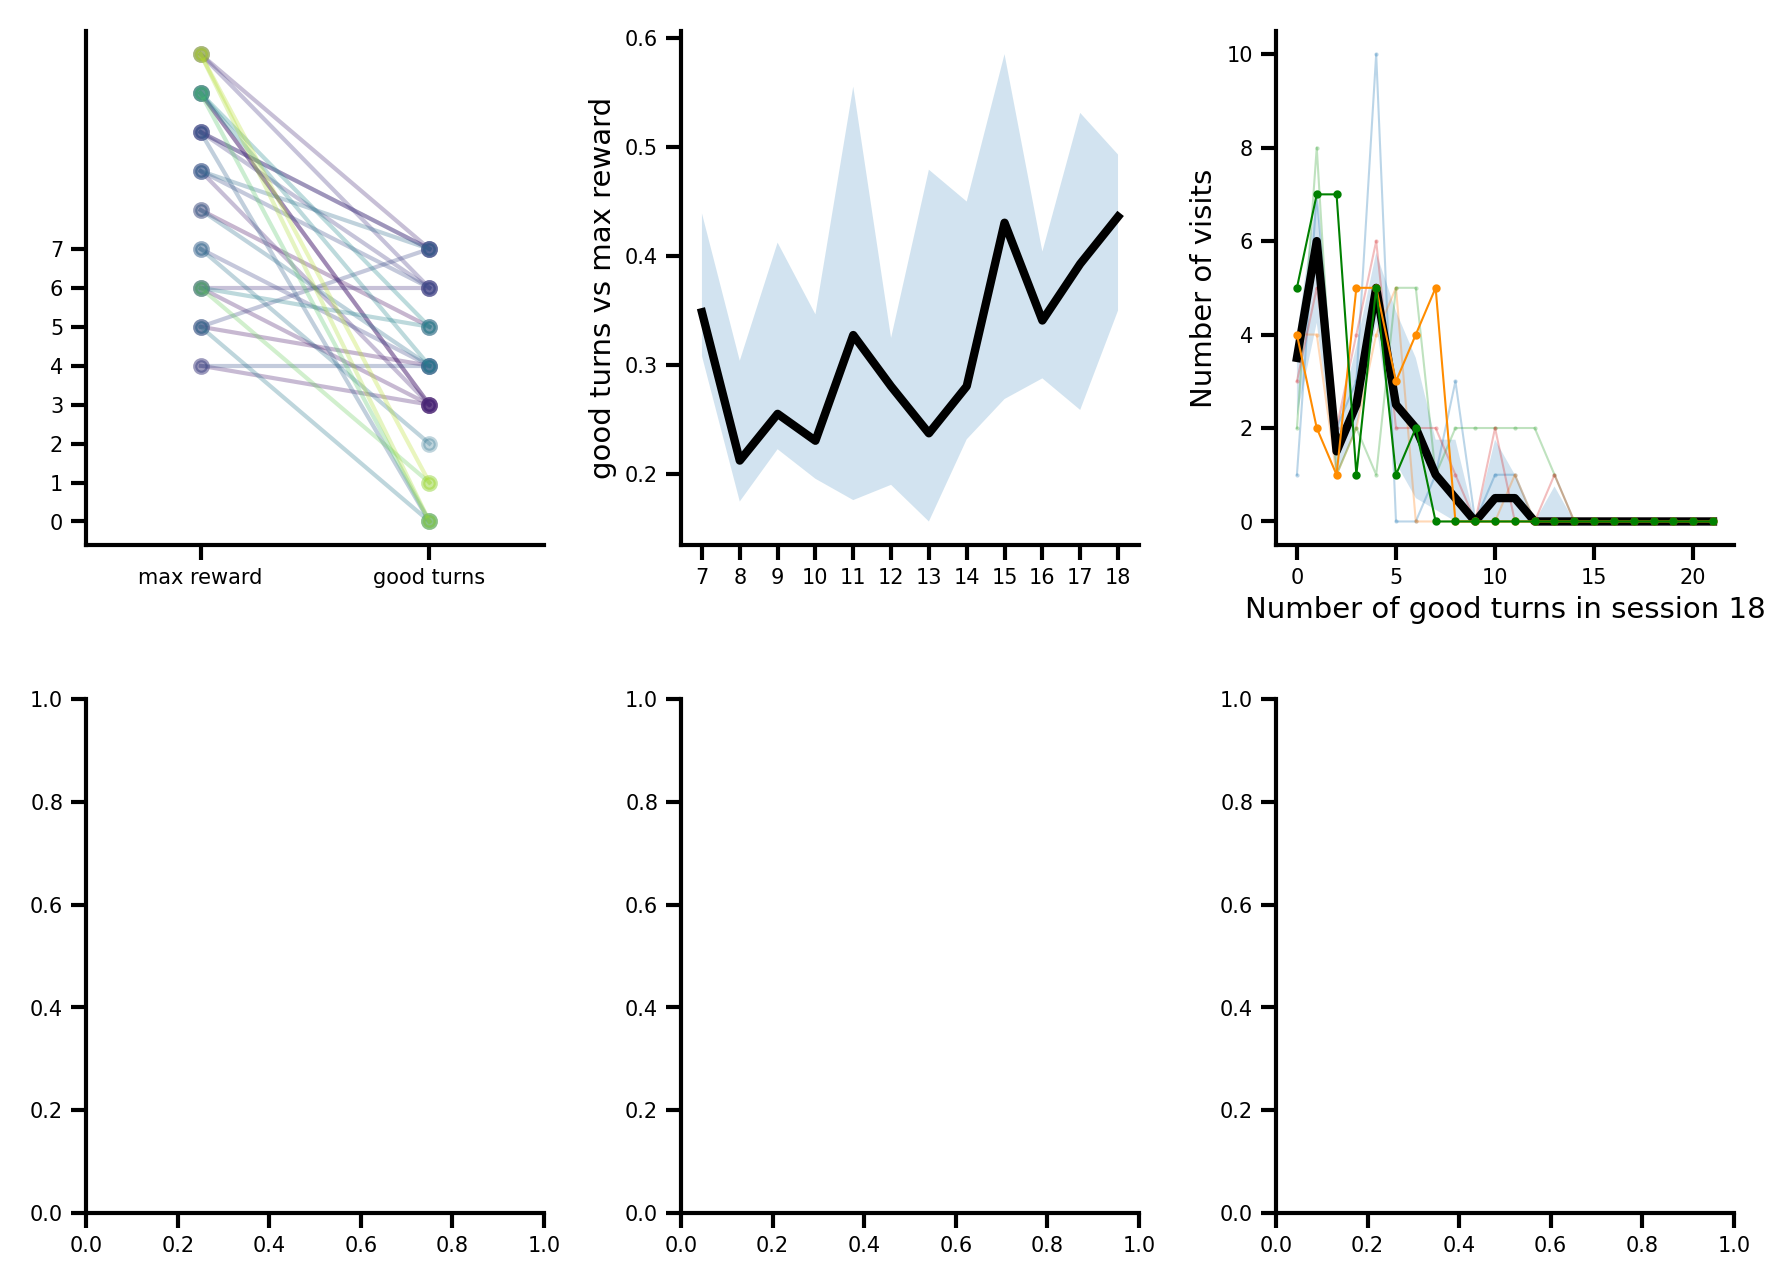

In [ ]:
mice_to_compare = ['MOUKA290', 'MOUKA310']
folder_path_mouse_to_process = f"/LocalData/ForagingMice/4TowerTaskMethodPaper/KenzaData/{mice_to_compare[0]}"

fig=plt.figure(figsize=(cm2inch(18), cm2inch(13)), dpi=300, constrained_layout=False, facecolor='w')
gs = fig.add_gridspec(2, 1, hspace=0.3, height_ratios=[1, 1])


#########################################

row1 = gs[0].subgridspec(1, 3, wspace=.3, hspace=.3, width_ratios=[1,1,1])

ax_11 = plt.subplot(row1[0])
ax_12 = plt.subplot(row1[1])
ax_13 = plt.subplot(row1[2])

plot_realised_vs_max(folder_path_mouse_to_process, 18, ax_11)
plot_realised_vs_max_per_session(path_to_data_folder, mice_to_analyse, 6, 18, ax_12)
plot_realised_per_mouse(path_to_data_folder, mice_to_analyse, 18, ax_13, mice_to_highlight=mice_to_compare, xrange=22)

row2 = gs[1].subgridspec(1, 3, wspace=.3, hspace=.3, width_ratios=[1,1,1])

ax_21 = plt.subplot(row2[0])
ax_22 = plt.subplot(row2[1])
ax_23 = plt.subplot(row2[2])


plot_realised_vs_max_rank(path_to_data_folder, mice_to_analyse, 18, ax_21, xlim=[0,30], ylim=[-4,12])


In [136]:
7 + 2*3 + 2*3 + 4 + 5 + 6 + 7 + 8 + 14 + 2*15 + 17

110

In [137]:
session_traj_df, session_turns_df, session_param_df=load_data(folder_path_mouse_to_process,'MOUKA290_20231207-1640')

In [138]:
int(False)

0

In [139]:
session_traj_df

,time,xposition,yposition
337,15.022,300.0,157.0
338,15.062,300.0,157.0
339,15.102,300.0,157.0
340,15.142,299.0,157.0
341,15.183,299.0,158.0
...,...,...,...
14949,599.855,42.0,56.0
14950,599.897,44.0,55.0
14951,599.938,50.0,53.0
14952,599.977,62.0,51.0


In [140]:
folder_path_mouse_to_process

'/LocalData/ForagingMice/4TowerTaskMethodPaper/KenzaData/MOUKA290'

In [141]:
folder_path_mouse_to_process = '/LocalData/ForagingMice/4TowerTaskMethodPaper/KenzaData/MOUKA313'
session_to_process = 'MOUKA313_20240529-1003'
output_pickle_filename = f"{session_to_process}_basic_processing_output.pickle"
output_pickle_filepath = os.path.join(folder_path_mouse_to_process, session_to_process, output_pickle_filename)
    
# Load the pickle file
with open(output_pickle_filepath, 'rb') as file:
    session_data = pickle.load(file)

runs_around_towers = session_data['all_epochs']['run_around_tower']

runs_around_towers

[[[0, 20],
  ['NW', 'E'],
  ['NW', 'S'],
  {'Rewarded': True,
   'direction': 'CW',
   'num_trapezeswitch': 1,
   'max_rewards': np.int64(7)},
  {'epoch_time': np.float64(15.007),
   'epoch_duration': np.float64(0.798),
   'epoch_distance': np.float64(12.91412123887352),
   'epoch_meanspeed': np.float64(16.18310932189664),
   'epoch_maxspeed': np.float64(40.400754356902816)}],
 [[111, 129],
  ['NW', 'S'],
  ['NW', 'W'],
  {'Rewarded': True,
   'direction': 'CW',
   'num_trapezeswitch': 1,
   'max_rewards': np.int64(7)},
  {'epoch_time': np.float64(19.451),
   'epoch_duration': np.float64(0.7199999999999989),
   'epoch_distance': np.float64(11.847551501523032),
   'epoch_meanspeed': np.float64(16.454932641004238),
   'epoch_maxspeed': np.float64(26.610785216861743)}],
 [[187, 213],
  ['NW', 'W'],
  ['NW', 'N'],
  {'Rewarded': True,
   'direction': 'CW',
   'num_trapezeswitch': 1,
   'max_rewards': np.int64(7)},
  {'epoch_time': np.float64(22.491),
   'epoch_duration': np.float64(1.03999

In [142]:
from collections import Counter

a = [1, 3, 2, 6, 3, 2, 8, 2, 9, 2, 7, 3]

# Create a counter objects
res = Counter(a)

print()